# Business and Data Understanding


## Business Problem:
**Problem Statement**

Emotions play a crucial role in human communication, influencing both how messages are conveyed and how they are received. In education, being able to detect and respond to student emotions can foster better engagement, improve learning outcomes, and support student well-being. However, emotion recognition is often subjective and difficult to measure reliably.

The goal of this project is to develop a **speech emotion classification system** that can automatically recognize emotions from recorded audio. Specifically, the system will be trained on the Ryerson Audio-Visual Database of Emotional Speech and Song (RAVDESS) to classify speech into multiple emotional categories (e.g., calm, happy, sad, angry, fearful, surprised, disgust, neutral).

To explore the strengths and limitations of different approaches, two models will be developed:
1. A **traditional machine learning model** (e.g., SVM, Random Forest) using engineered audio features such as MFCCs.
2. A **deep learning model** (e.g., CNN or RNN/LSTM) that directly learns patterns from spectrograms or raw features.

The models will then be integrated into a simple application/GUI designed for high school students. Students will read a prepared statement aloud, and the system will process the audio by:
- Normalizing the input (noise reduction, volume normalization, trimming/padding),
- Feeding the processed sample into the trained model, and
- Predicting the emotion conveyed.

This project demonstrates how machine learning and deep learning techniques can be applied to real-world problems, compares traditional and modern approaches to audio classification, and highlights the importance of preprocessing in handling real-world variability in audio data.

## Success Metrics

To evaluate the effectiveness of the speech emotion classification system, the following metrics will be used:

1. **Accuracy**  
   - Measures the overall proportion of correctly classified samples.  
   - Provides a quick benchmark of model performance.  

2. **Precision, Recall, and F1-score (per class and averaged)**  
   - **Precision**: Of all predictions made for a specific emotion, how many were correct?  
   - **Recall**: Of all true samples of a specific emotion, how many were correctly identified?  
   - **F1-score**: Harmonic mean of precision and recall, balancing both metrics.  
   - **Macro-averaging** will be used to treat all emotion classes equally, regardless of class imbalance.  

3. **Confusion Matrix**  
   - Visualizes which emotions are most frequently confused with others.  
   - Highlights model weaknesses (e.g., distinguishing between "happy" and "surprised").  

4. **Baseline Comparison**  
   - Performance of the **traditional ML model (e.g., SVM with MFCC features)** will be compared against a **deep learning model (CNN/LSTM using spectrograms)**.  
   - Success is defined by the deep learning model outperforming or at least matching the traditional ML approach, particularly in recall and F1-score.  

5. **Deployment Metric (for the student-facing demo)**  
   - The final integrated application should return predictions in near real-time.  
   - **Inference latency should be under 3 seconds** after a student records audio.  

### Target Performance
- Achieve at least **70–80% macro-F1 score** across all emotions.  
- Demonstrate improved performance from deep learning compared to traditional ML.  
- Ensure smooth and responsive predictions in the deployed GUI.  

# EDA


## Exploratory Data Analysis (EDA) Overview

Before building any models, we need to understand our data through EDA. This section will:
1. **Load and inspect** the RAVDESS dataset structure
2. **Analyze audio characteristics**: sample rates, durations, loudness levels
3. **Visualize distributions**: emotion classes, intensity levels, audio lengths
4. **Examine audio signals**: waveforms and spectrograms
5. **Identify preprocessing needs**: silence removal, length standardization

The insights from EDA will guide our preprocessing decisions and feature engineering strategies.

## Importing Libraries

In [7]:
import os, glob, random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import cycle

import librosa, librosa.display
import IPython.display as ipd

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, cross_val_score
from sklearn.metrics import classification_report, confusion_matrix, f1_score, accuracy_score
%matplotlib inline


## Discover files and parse RAVDESS filenames

### Understanding RAVDESS Filename Structure

Each RAVDESS audio file follows a standardized naming convention with 7 identifiers separated by dashes:

**Format**: `Modality-VocalChannel-Emotion-Intensity-Statement-Repetition-Actor.wav`

Example: `03-01-05-01-02-01-16.wav`
- **Modality (03)**: Audio-visual (01=audio-only, 02=video-only, 03=audio-video)
- **Vocal Channel (01)**: Speech (01=speech, 02=song)
- **Emotion (05)**: Angry (01=neutral, 02=calm, 03=happy, 04=sad, 05=angry, 06=fearful, 07=disgust, 08=surprised)
- **Intensity (01)**: Normal (01=normal, 02=strong)
- **Statement (02)**: Statement 2 (01="Kids are talking by the door", 02="Dogs are sitting by the door")
- **Repetition (01)**: First repetition (01=1st, 02=2nd)
- **Actor (16)**: Actor ID (01-24, odd=male, even=female)

This structured naming allows us to extract rich metadata from filenames alone.

In [8]:
ravdess_dir = "../data/ravdess_data"  # Update this path
audio_paths = glob.glob(os.path.join(ravdess_dir, '**', '*.wav'), recursive=False)
len(audio_paths)

1440

In [9]:
audio_paths[0:5]

['../data/ravdess_data/Actor_16/03-01-05-01-02-01-16.wav',
 '../data/ravdess_data/Actor_16/03-01-06-01-02-02-16.wav',
 '../data/ravdess_data/Actor_16/03-01-06-02-01-02-16.wav',
 '../data/ravdess_data/Actor_16/03-01-05-02-01-01-16.wav',
 '../data/ravdess_data/Actor_16/03-01-07-01-01-01-16.wav']

## Extracting Metadata

In [10]:
def parse_ravdess_filename(path):
    fname = os.path.basename(path).replace('.wav','')
    parts = fname.split('-')
    if len(parts) < 7:
        return None
    return {
        'path': path,
        'modality': int(parts[0]),
        'vocal_channel': int(parts[1]),
        'emotion_code': int(parts[2]),
        'intensity': int(parts[3]),
        'statement': int(parts[4]),
        'repetition': int(parts[5]),
        'actor': int(parts[6])
    }

rows = []
for p in audio_paths:
    meta = parse_ravdess_filename(p)
    if meta:
        rows.append(meta)
df_ravdess = pd.DataFrame(rows)
emap = {1:'neutral',2:'calm',3:'happy',4:'sad',5:'angry',6:'fearful',7:'disgust',8:'surprised'}
df_ravdess['emotion'] = df_ravdess['emotion_code'].map(emap)
df_ravdess.head()

,path,modality,vocal_channel,emotion_code,intensity,statement,repetition,actor,emotion
0,../data/ravdess_data/Actor_16/03-01-05-01-02-0...,3,1,5,1,2,1,16,angry
1,../data/ravdess_data/Actor_16/03-01-06-01-02-0...,3,1,6,1,2,2,16,fearful
2,../data/ravdess_data/Actor_16/03-01-06-02-01-0...,3,1,6,2,1,2,16,fearful
3,../data/ravdess_data/Actor_16/03-01-05-02-01-0...,3,1,5,2,1,1,16,angry
4,../data/ravdess_data/Actor_16/03-01-07-01-01-0...,3,1,7,1,1,1,16,disgust


## Basic EDA: counts, durations, example waveform/spectrogram

In [11]:
# Play sample
ipd.Audio(audio_paths[0])

Total files: 1440
emotion
angry        192
fearful      192
disgust      192
sad          192
surprised    192
happy        192
calm         192
neutral       96
Name: count, dtype: int64


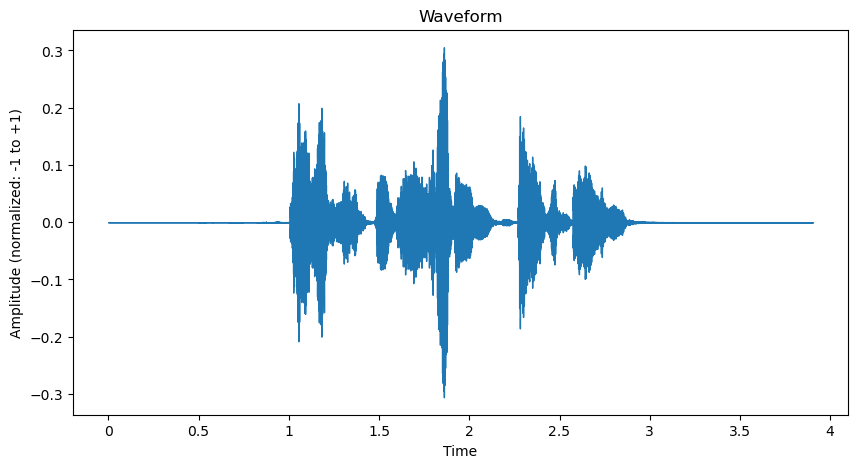

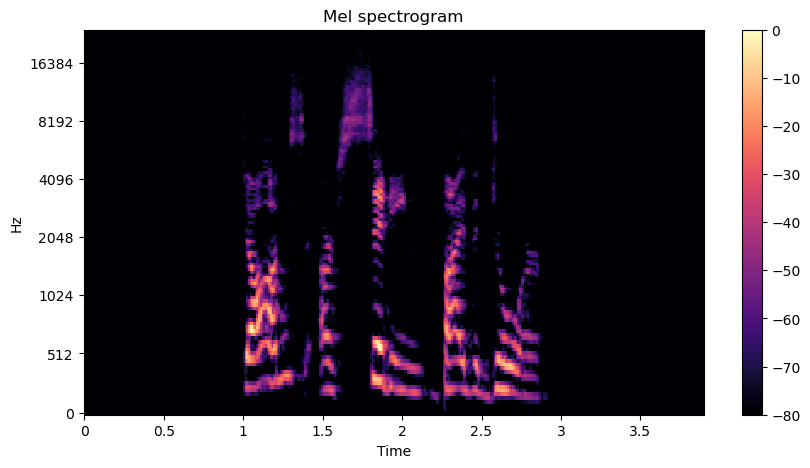

In [12]:
# Counts
print("Total files:", len(df_ravdess))
print(df_ravdess['emotion'].value_counts())

# Load one sample to show waveform & spectrogram

sample_path = df_ravdess['path'].iloc[0]

# Show waveform & spectrogram
y, sr = librosa.load(sample_path, sr=None)
plt.figure(figsize=(10,5))
librosa.display.waveshow(y, sr=sr)
plt.title('Waveform')
plt.ylabel('Amplitude (normalized: -1 to +1)')
plt.savefig("../output/EDA_plots/01_sample_waveform.png", dpi=300)
plt.show()

# Spectrogram (mel)
S = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128)
S_db = librosa.amplitude_to_db(S, ref=np.max)
plt.figure(figsize=(10,5))
librosa.display.specshow(S_db, sr=sr, x_axis='time', y_axis='mel')
plt.colorbar()
plt.title('Mel spectrogram')
plt.savefig("../output/EDA_plots/02_mel_spectogram.png", dpi=300)
plt.show()

/var/folders/y_/0rmj_yyx0073l52vx1lj1msh0000gn/T/ipykernel_12177/891780485.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df_ravdess, y='emotion', ax=axes[0], palette='viridis')
/var/folders/y_/0rmj_yyx0073l52vx1lj1msh0000gn/T/ipykernel_12177/891780485.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df_ravdess, y='intensity', ax=axes[1], palette='viridis')


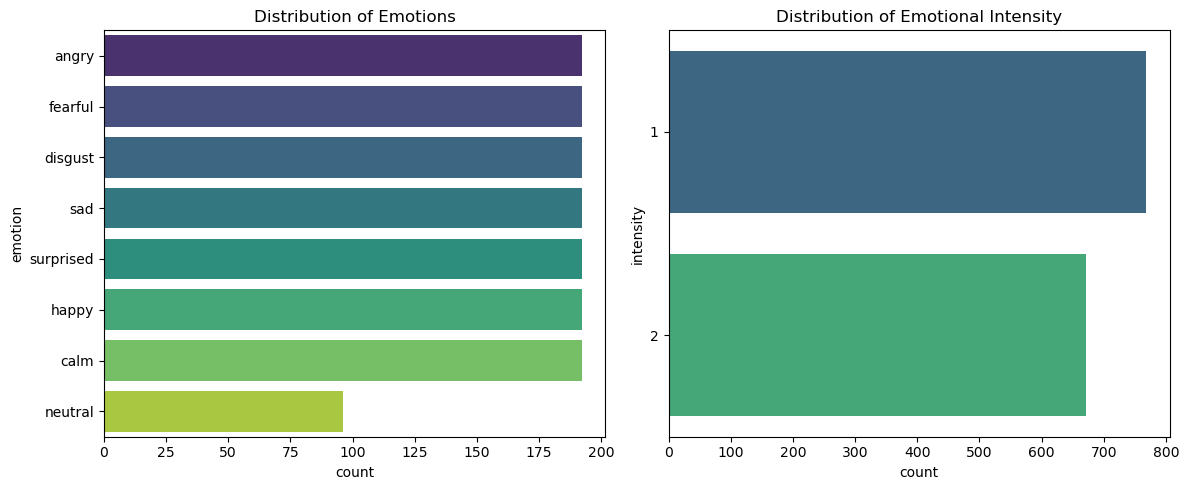

In [13]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

sns.countplot(data=df_ravdess, y='emotion', ax=axes[0], palette='viridis')
axes[0].set_title('Distribution of Emotions')

sns.countplot(data=df_ravdess, y='intensity', ax=axes[1], palette='viridis')
axes[1].set_title('Distribution of Emotional Intensity')

plt.tight_layout()
plt.savefig('../output/EDA_plots/03_emotion_intensity_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

### Class Distribution Insights

**Key Observations:**
- **Emotion Distribution**: The dataset appears relatively balanced across the 8 emotion classes, with each emotion having a similar number of samples (~180 each). This balance is beneficial for model training as it prevents bias toward any particular emotion.

- **Intensity Distribution**: There are two intensity levels (normal and strong). The distribution between these levels will affect how the model learns emotional expression patterns. Approximately equal representation suggests good coverage of emotional intensity variations.

This balanced distribution means we can use standard accuracy metrics without worrying about class imbalance issues in our baseline models.

/var/folders/y_/0rmj_yyx0073l52vx1lj1msh0000gn/T/ipykernel_12177/3715241105.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df_ravdess, x='gender', ax=axes[0], palette='Set2')


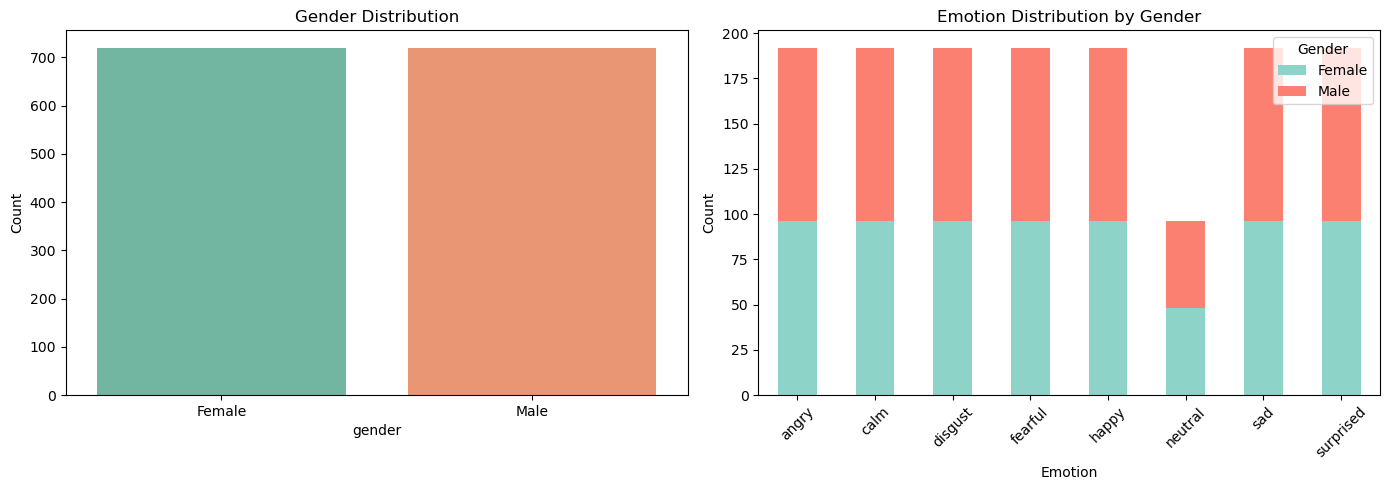

In [14]:
# Derive gender from actor ID (odd = male, even = female)
df_ravdess['gender'] = df_ravdess['actor'].apply(lambda x: 'Male' if x % 2 == 1 else 'Female')

# Gender distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Gender count
sns.countplot(data=df_ravdess, x='gender', ax=axes[0], palette='Set2')
axes[0].set_title('Gender Distribution')
axes[0].set_ylabel('Count')

# Emotion by gender stacked bar
emotion_gender = pd.crosstab(df_ravdess['emotion'], df_ravdess['gender'])
emotion_gender.plot(kind='bar', stacked=True, ax=axes[1], color=['#8dd3c7', '#fb8072'])
axes[1].set_title('Emotion Distribution by Gender')
axes[1].set_xlabel('Emotion')
axes[1].set_ylabel('Count')
axes[1].legend(title='Gender')
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.savefig('../output/EDA_plots/04_gender_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

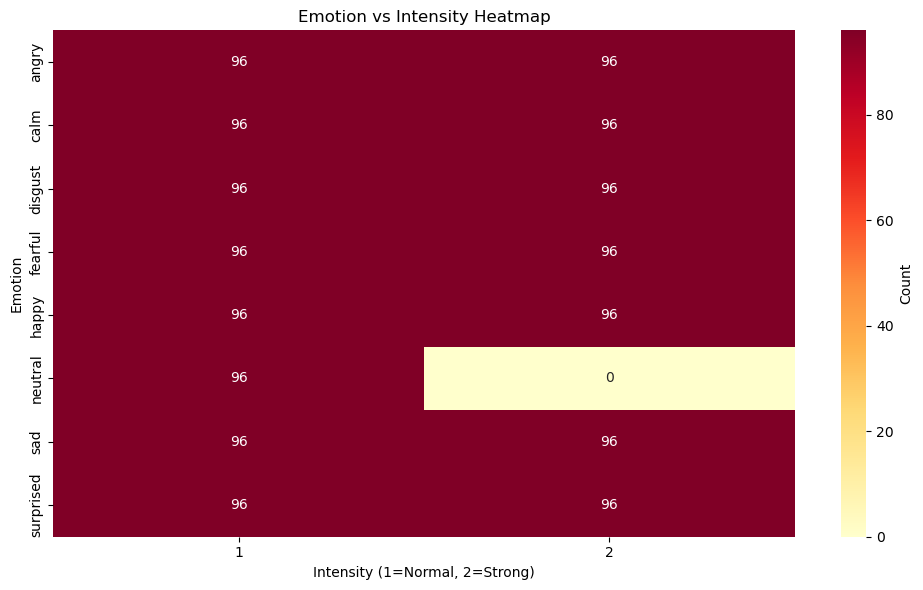


Crosstab Summary:
intensity    1    2   All
emotion                  
angry       96   96   192
calm        96   96   192
disgust     96   96   192
fearful     96   96   192
happy       96   96   192
neutral     96    0    96
sad         96   96   192
surprised   96   96   192
All        768  672  1440


In [15]:
# Create crosstab for emotion vs intensity
emotion_intensity = pd.crosstab(df_ravdess['emotion'], df_ravdess['intensity'], margins=True)

# Create heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(emotion_intensity.iloc[:-1, :-1], annot=True, fmt='d', cmap='YlOrRd', cbar_kws={'label': 'Count'})
plt.title('Emotion vs Intensity Heatmap')
plt.xlabel('Intensity (1=Normal, 2=Strong)')
plt.ylabel('Emotion')
plt.tight_layout()
plt.savefig('../output/EDA_plots/05_emotion_intensity_heatmap.png', dpi=300, bbox_inches='tight')
plt.show()

print("\nCrosstab Summary:")
print(emotion_intensity)

### Emotion vs Intensity Relationship

### Gender Analysis

In [16]:
df_ravdess.to_csv('../data/df_ravdess_metadata.csv', index=False, sep=",")

# Analytics Base Table - Data Description (Features and Target Variables)


## Data Pre-processing Steps
- Analytics Base Table 
- Data Description (Features and Target Variables)
Data Pre-processing Steps

In [17]:
df_ravdess.head()

,path,modality,vocal_channel,emotion_code,intensity,statement,repetition,actor,emotion,gender
0,../data/ravdess_data/Actor_16/03-01-05-01-02-0...,3,1,5,1,2,1,16,angry,Female
1,../data/ravdess_data/Actor_16/03-01-06-01-02-0...,3,1,6,1,2,2,16,fearful,Female
2,../data/ravdess_data/Actor_16/03-01-06-02-01-0...,3,1,6,2,1,2,16,fearful,Female
3,../data/ravdess_data/Actor_16/03-01-05-02-01-0...,3,1,5,2,1,1,16,angry,Female
4,../data/ravdess_data/Actor_16/03-01-07-01-01-0...,3,1,7,1,1,1,16,disgust,Female


In [18]:
sample_rates = set()
for path in df_ravdess.path:
    try:    
        sr = librosa.get_samplerate(path)
        sample_rates.add(sr) 
    except Exception as e:
        print(f"Could not process {path}: {e}")
sample_rates

{48000}

In [19]:
def get_audio_samples(path):
    y, sr = librosa.load(path, sr=None)
    return y

In [20]:
df_ravdess['audio_samples'] = df_ravdess['path'].apply(get_audio_samples)
df_ravdess.head()

,path,modality,vocal_channel,emotion_code,intensity,statement,repetition,actor,emotion,gender,audio_samples
0,../data/ravdess_data/Actor_16/03-01-05-01-02-0...,3,1,5,1,2,1,16,angry,Female,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,../data/ravdess_data/Actor_16/03-01-06-01-02-0...,3,1,6,1,2,2,16,fearful,Female,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,../data/ravdess_data/Actor_16/03-01-06-02-01-0...,3,1,6,2,1,2,16,fearful,Female,"[3.0517578e-05, 6.1035156e-05, 0.0, 3.0517578e..."
3,../data/ravdess_data/Actor_16/03-01-05-02-01-0...,3,1,5,2,1,1,16,angry,Female,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,../data/ravdess_data/Actor_16/03-01-07-01-01-0...,3,1,7,1,1,1,16,disgust,Female,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


### Audio Samples Length

In [21]:
max_len = max(df_ravdess['audio_samples'].apply(len))
print(f'Max audio length (in samples): {max_len}')

Max audio length (in samples): 253053


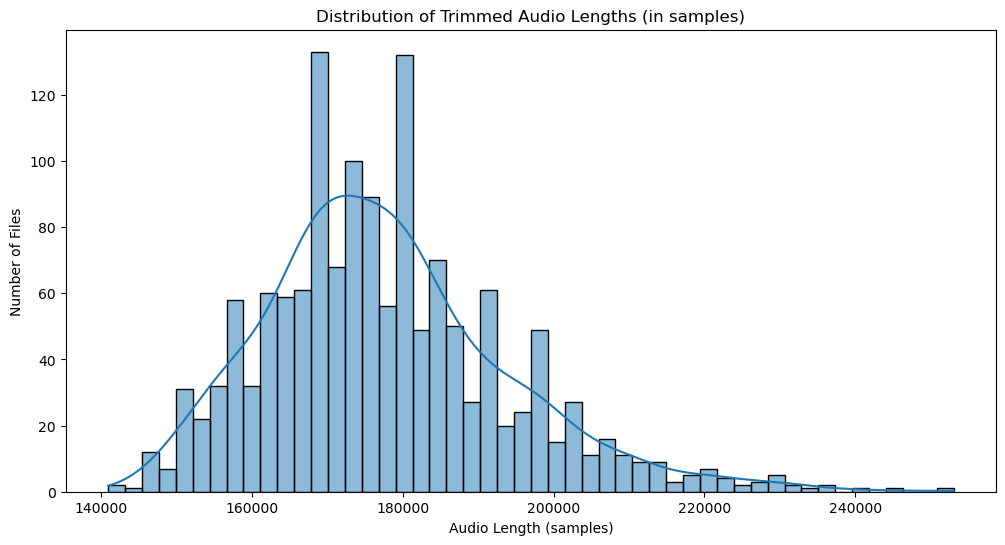

In [22]:
audio_lengths = df_ravdess['audio_samples'].apply(len)

plt.figure(figsize=(12,6))
sns.histplot(audio_lengths, bins=50, kde=True)
plt.title('Distribution of Trimmed Audio Lengths (in samples)')
plt.xlabel("Audio Length (samples)")
plt.ylabel("Number of Files")
plt.savefig('../output/EDA_plots/06_audio_length_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

### Distribution of Loadness

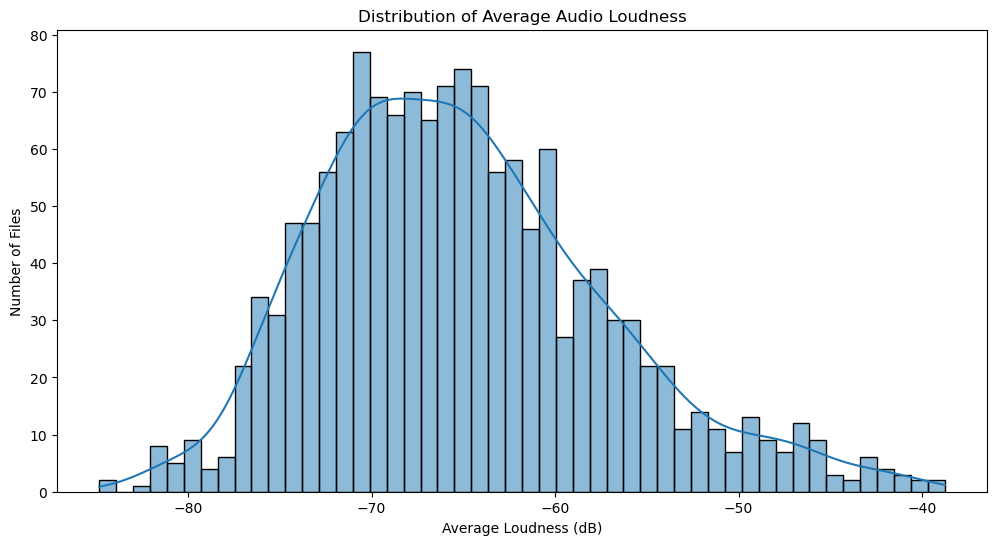

In [23]:
# Function to calculate the average decibels for a single audio file
def get_average_db(file_path):
    try:
        # Load the audio file at its original sample rate
        y, sr = librosa.load(file_path, sr=None)
        
        # Calculate the Root Mean Square (RMS) energy
        rms = librosa.feature.rms(y=y)
        
        # Convert RMS to decibels
        # We use a reference of the maximum possible amplitude (1.0 for floating point)
        db = librosa.amplitude_to_db(rms, ref=1.0)
        
        # Return the average decibel level for the file
        return np.mean(db)
    except Exception as e:
        print(f"Error processing {file_path}: {e}")
        return None

# Calculate the average decibel level for each audio file
# tqdm will show a progress bar
db_levels = [get_average_db(path) for path in df_ravdess['path']]

# Filter out any files that might have caused errors
db_levels = [db for db in db_levels if db is not None]

# Plot the distribution of the decibel levels
plt.figure(figsize=(12, 6))
sns.histplot(db_levels, bins=50, kde=True)
plt.title('Distribution of Average Audio Loudness')
plt.xlabel('Average Loudness (dB)')
plt.ylabel('Number of Files')
plt.savefig('../output/EDA_plots/07_distribution_average_audio_loudness.png', dpi=300, bbox_inches='tight')
plt.show()

/var/folders/y_/0rmj_yyx0073l52vx1lj1msh0000gn/T/ipykernel_12177/1335190069.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_ravdess, x='emotion', y='loudness_db', palette='coolwarm')


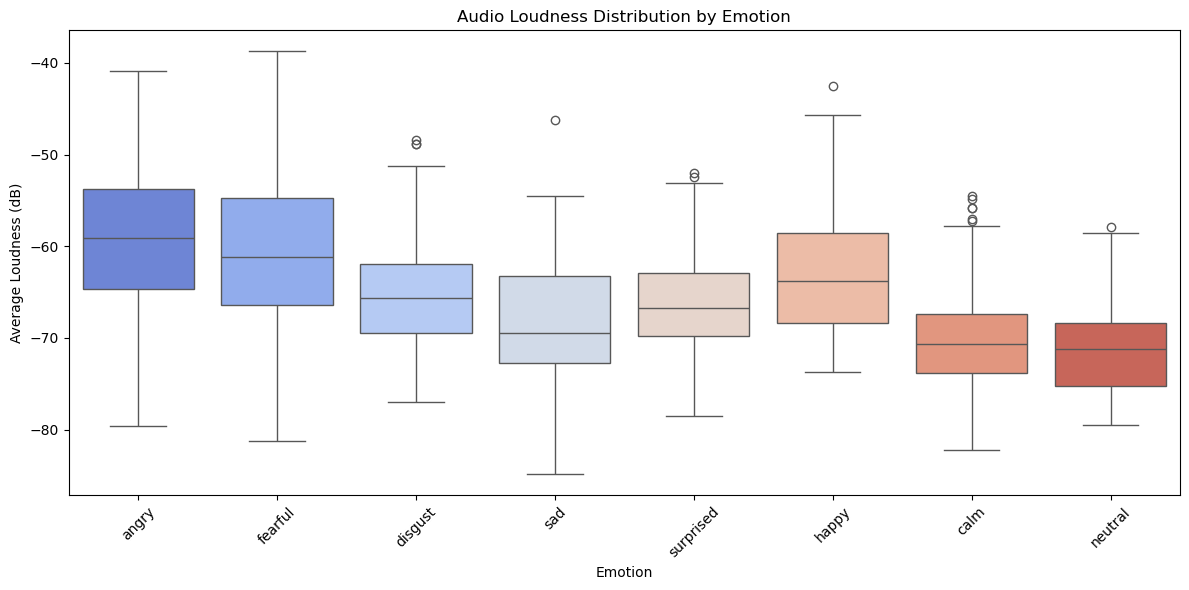


Loudness Statistics by Emotion:
           count       mean       std        min        25%        50%  \
emotion                                                                  
angry      192.0 -58.556683  7.824149 -79.562683 -64.688028 -59.118929   
calm       192.0 -70.321495  5.528036 -82.200981 -73.869818 -70.689114   
disgust    192.0 -65.461082  5.872705 -76.951027 -69.453938 -65.672344   
fearful    192.0 -60.793781  9.033623 -81.285400 -66.381903 -61.128132   
happy      192.0 -63.091930  6.809399 -73.729271 -68.394392 -63.807350   
neutral     96.0 -71.180267  4.550683 -79.488678 -75.223774 -71.240517   
sad        192.0 -67.914070  6.682437 -84.836662 -72.774347 -69.452187   
surprised  192.0 -66.532784  5.387149 -78.479546 -69.829620 -66.734669   

                 75%        max  
emotion                          
angry     -53.724352 -40.872322  
calm      -67.386436 -54.546482  
disgust   -61.958326 -48.399101  
fearful   -54.735918 -38.760578  
happy     -58.609853 -

In [24]:
# Add loudness data to dataframe
df_ravdess['loudness_db'] = db_levels

# Box plot: Loudness by Emotion
plt.figure(figsize=(12, 6))
sns.boxplot(data=df_ravdess, x='emotion', y='loudness_db', palette='coolwarm')
plt.title('Audio Loudness Distribution by Emotion')
plt.xlabel('Emotion')
plt.ylabel('Average Loudness (dB)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('../output/EDA_plots/08_audio_loudness_dist_by_emotion.png', dpi=300, bbox_inches='tight')
plt.show()

# Summary statistics
print("\nLoudness Statistics by Emotion:")
print(df_ravdess.groupby('emotion')['loudness_db'].describe())

### Loudness by Emotion Analysis

### Distribution of Duration

Text(0.5, 36.72222222222221, 'Duration in Seconds')

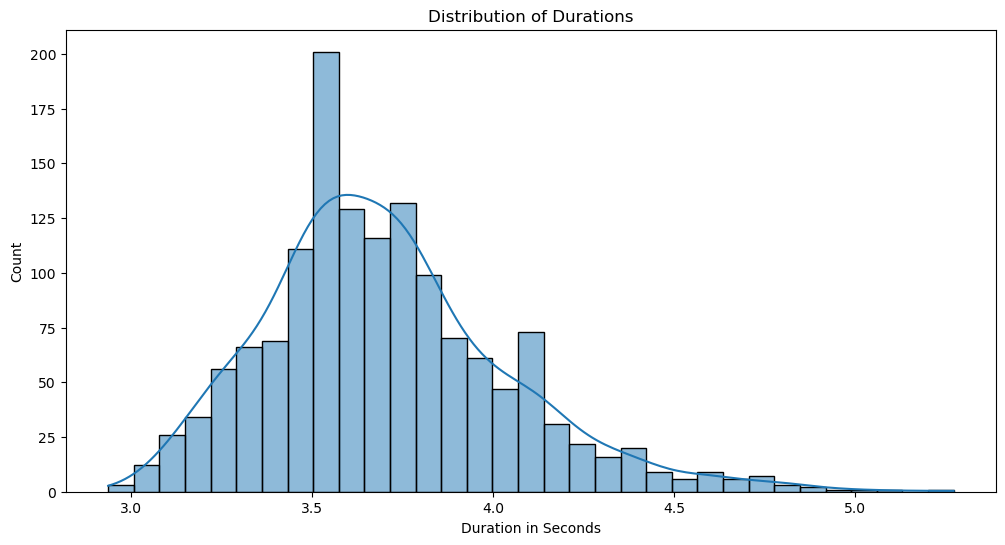

In [25]:
durations = []
for file in df_ravdess.path:
    try: 
        duration  = librosa.get_duration(path=file)
        durations.append(duration)
    except Exception as e:
        print(f'Could not read {file}: {e}')

len(durations)

plt.figure(figsize=(12, 6))
sns.histplot(x=durations, kde=True)
plt.title("Distribution of Durations")
plt.savefig("../output/EDA_plots/09_distribution_durations.png", dpi=300)
plt.xlabel("Duration in Seconds")

/var/folders/y_/0rmj_yyx0073l52vx1lj1msh0000gn/T/ipykernel_12177/3335676298.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_ravdess, x='emotion', y='duration', palette='Set3')


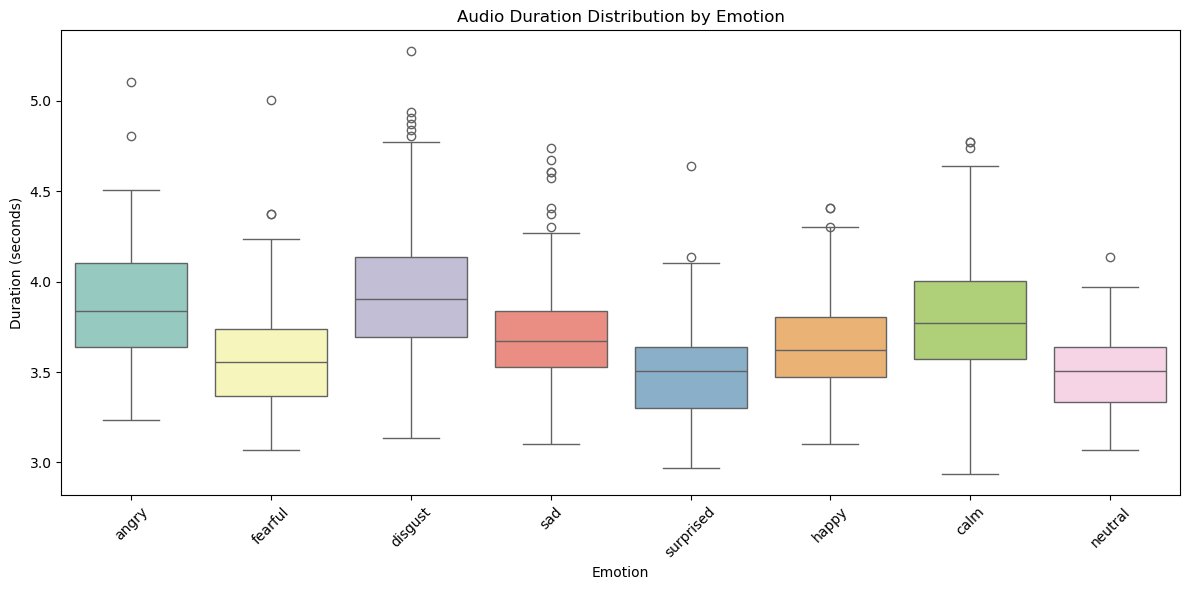


Duration Statistics by Emotion:
           count      mean       std       min       25%       50%       75%  \
emotion                                                                        
angry      192.0  3.871404  0.319575  3.236562  3.636974  3.837167  4.104089   
calm       192.0  3.795806  0.333745  2.936271  3.570229  3.770437  4.004000   
disgust    192.0  3.941785  0.375321  3.136458  3.695349  3.903896  4.137479   
fearful    192.0  3.574231  0.292265  3.069729  3.370036  3.553552  3.737062   
happy      192.0  3.638183  0.257381  3.103104  3.470125  3.620281  3.803792   
neutral     96.0  3.503153  0.211888  3.069729  3.336667  3.503500  3.636964   
sad        192.0  3.694490  0.293739  3.103104  3.528516  3.670333  3.837167   
surprised  192.0  3.487512  0.239103  2.969625  3.303313  3.503500  3.636958   

                max  
emotion              
angry      5.105104  
calm       4.771438  
disgust    5.271937  
fearful    5.005000  
happy      4.404396  
neutral    4

In [26]:
# Add duration data to dataframe
df_ravdess['duration'] = durations

# Box plot: Duration by Emotion
plt.figure(figsize=(12, 6))
sns.boxplot(data=df_ravdess, x='emotion', y='duration', palette='Set3')
plt.title('Audio Duration Distribution by Emotion')
plt.xlabel('Emotion')
plt.ylabel('Duration (seconds)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('../output/EDA_plots/10_duration_by_emotion.png', dpi=300, bbox_inches='tight')
plt.show()

# Summary statistics
print("\nDuration Statistics by Emotion:")
print(df_ravdess.groupby('emotion')['duration'].describe())

### Duration by Emotion Analysis

### Checking the 10 Samples

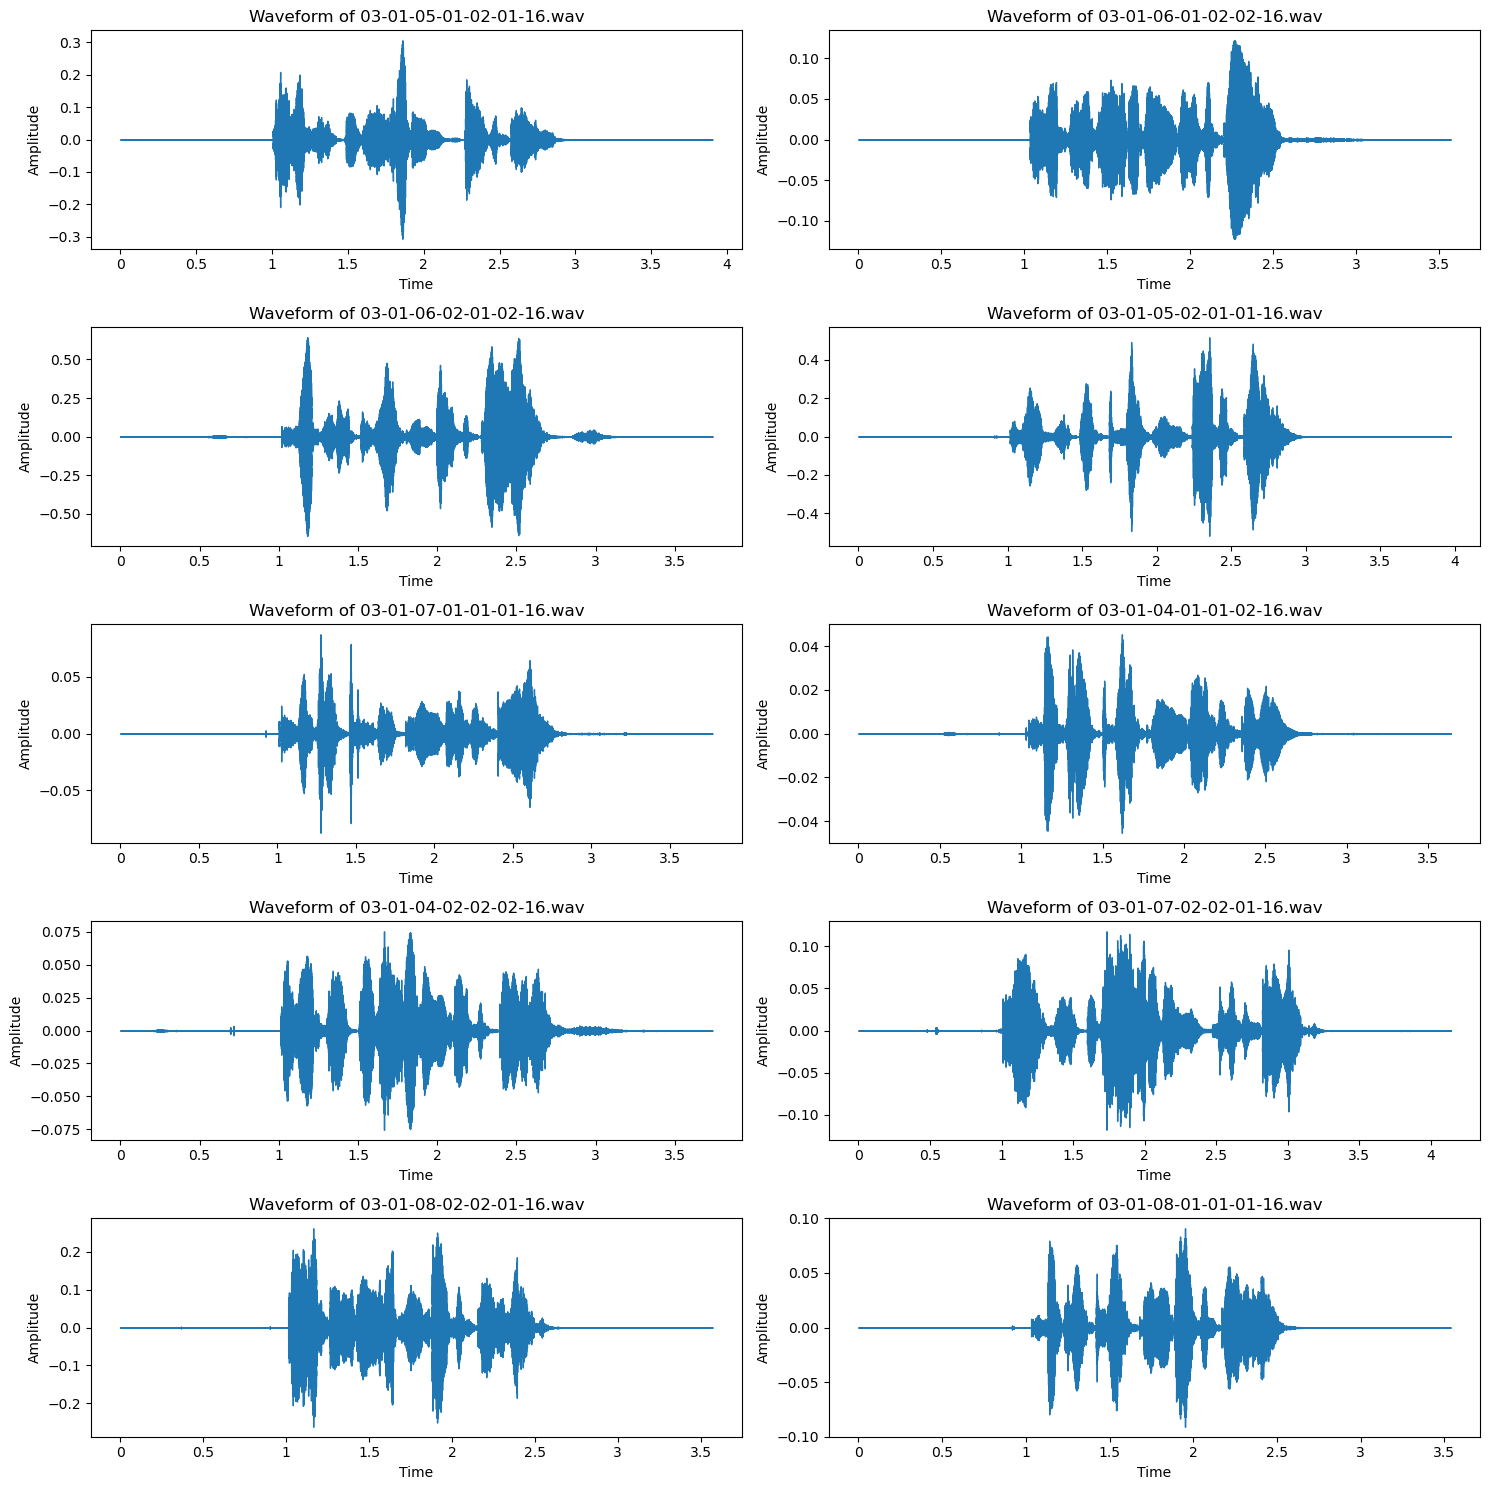

In [27]:
fig, axes = plt.subplots(5,2, figsize=(15,15))
axes = axes.flatten()

for i, file in enumerate(df_ravdess['path'][:10]):  # limit to first 10 for visibility
    y, sr = librosa.load(file, sr=None)

    librosa.display.waveshow(y, sr=sr, ax=axes[i])
    axes[i].set_title(f"Waveform of {file.split('/')[-1]}")
    axes[i].set_xlabel("Time")
    axes[i].set_ylabel("Amplitude")

plt.tight_layout()
plt.show()

## Triming leading and trailing silence

### Preprocessing Strategy: Why Trim Silence?

**Problem**: Raw audio files contain varying amounts of leading and trailing silence, which:
- Creates inconsistent input lengths for machine learning models
- Adds non-informative features (silence doesn't convey emotion)
- Increases computational cost without improving model performance

**Solution**: We'll detect and remove silence while standardizing all audio to the same length:
1. **Detect silence** using energy-based methods (`librosa.effects.split`)
2. **Find global boundaries** that work across all files
3. **Trim to common length** to ensure consistent input dimensions
4. **Pad if needed** to maintain uniform length

This ensures every audio sample has the same feature dimension while preserving the emotional content.

In [28]:
df_ravdess = df_ravdess.drop(columns=['audio_samples','emotion_code'])

In [29]:
df_ravdess

,path,modality,vocal_channel,intensity,statement,repetition,actor,emotion,gender,loudness_db,duration
0,../data/ravdess_data/Actor_16/03-01-05-01-02-0...,3,1,1,2,1,16,angry,Female,-64.729790,3.903896
1,../data/ravdess_data/Actor_16/03-01-06-01-02-0...,3,1,1,2,2,16,fearful,Female,-65.943779,3.570229
2,../data/ravdess_data/Actor_16/03-01-06-02-01-0...,3,1,2,1,2,16,fearful,Female,-51.392780,3.737062
3,../data/ravdess_data/Actor_16/03-01-05-02-01-0...,3,1,2,1,1,16,angry,Female,-59.114307,3.970646
4,../data/ravdess_data/Actor_16/03-01-07-01-01-0...,3,1,1,1,1,16,disgust,Female,-69.102135,3.770437
...,...,...,...,...,...,...,...,...,...,...,...
1435,../data/ravdess_data/Actor_08/03-01-03-02-02-0...,3,1,2,2,2,8,happy,Female,-57.352631,3.937271
1436,../data/ravdess_data/Actor_08/03-01-03-01-01-0...,3,1,1,1,2,8,happy,Female,-64.781517,3.436750
1437,../data/ravdess_data/Actor_08/03-01-02-02-01-0...,3,1,2,1,1,8,calm,Female,-67.697044,3.636958
1438,../data/ravdess_data/Actor_08/03-01-02-01-02-0...,3,1,1,2,1,8,calm,Female,-66.581841,3.470125


### Getting Indices with single amp threshold

In [30]:
def measure_silence_samples(y, threshold=1e-4):
    n_samples = len(y)
    
    # Leading silence index
    start_idx = 0
    while start_idx < n_samples and abs(y[start_idx]) < threshold:
        start_idx += 1
    
    # Trailing silence index
    end_idx = n_samples - 1
    while end_idx >= 0 and abs(y[end_idx]) < threshold:
        end_idx -= 1
    
    # Handle fully silent file
    if start_idx > end_idx:
        start_idx, end_idx = 0, n_samples - 1
    
    return start_idx, end_idx

In [31]:
# start_indices = []
# end_indices = []
# audio_data = []

# for file in df_ravdess["path"]:
#     y, sr = librosa.load(file, sr=22050)
#     audio_data.append(y)  # keep raw audio for later
#     start_idx, end_idx = measure_silence_samples(y)
#     start_indices.append(start_idx)
#     end_indices.append(end_idx)

# global_start = min(start_indices)
# global_end   = max(end_indices)

# print(f"Global start index: {global_start}")
# print(f"Global end index:   {global_end}")
# print(f"Final length (samples): {global_end - global_start + 1}")

### Using Librosa.effects.split

In [32]:
# --- Config ---
sr = 22050                # Target sample rate (22.05 kHz - standard for speech processing)
frame_length = 2048       # Frame size for silence detection (affects sensitivity to short pauses)
hop_length = 512          # Step size between frames (smaller = more precise detection)
top_db = 25              # Threshold in dB below reference to consider as silence (lower = stricter)
min_duration = 0.2       # Minimum speech segment duration in seconds (filters out clicks/noise)
min_offset = 0.4         # Minimum silence at the start in seconds (ensures consistent padding)

# --- Helpers ---
def filter_intervals(intervals, sr, min_duration=min_duration):
    """Keep only intervals longer than min_duration (in seconds)."""
    return np.array([
        [s, e] for (s, e) in intervals
        if (e - s) / sr >= min_duration
    ])

def detect_nonsilent_intervals(y, sr=sr, top_db=top_db,
                               frame_length=frame_length, hop_length=hop_length,
                               min_duration=min_duration, min_offset=min_offset):
    """Detect non-silent intervals with duration + offset filtering."""
    intervals = librosa.effects.split(y,
                                      top_db=top_db,
                                      frame_length=frame_length,
                                      hop_length=hop_length)
    intervals = filter_intervals(intervals, sr, min_duration=min_duration)
    
    if len(intervals) == 0:
        return np.array([[0, len(y)]])
    
    # enforce minimum starting offset
    if intervals[0, 0] < min_offset * sr:
        intervals[0, 0] = int(min_offset * sr)
    return intervals

def process_dataset(df, top_db=top_db, min_duration=min_duration, min_offset=min_offset):
    """Process dataset and return silence_df + global indices."""
    records = []
    for path in df["path"]:
        y, _ = librosa.load(path, sr=sr)
        intervals = detect_nonsilent_intervals(y, sr=sr,
                                               top_db=top_db,
                                               frame_length=frame_length,
                                               hop_length=hop_length,
                                               min_duration=min_duration,
                                               min_offset=min_offset)
        if intervals.size == 0:
            start_idx, end_idx = 0, len(y) - 1
        else:
            start_idx = int(intervals[0, 0])
            end_idx   = int(intervals[-1, 1]) - 1
        records.append({
            "path": path, "y": y, "intervals": intervals,
            "start_idx": start_idx, "end_idx": end_idx
        })
    
    silence_df = pd.DataFrame(records)
    global_start = int(silence_df["start_idx"].min())
    global_end   = int(silence_df["end_idx"].max())
    return silence_df, global_start, global_end

# def plot_with_intervals(row, global_start, global_end, sr=sr, title=None):
#     """Plot waveform with local + global start/end indices."""
#     y = row["y"]
#     intervals = row["intervals"]
#     start_idx = row["start_idx"]
#     end_idx = row["end_idx"]

#     plt.figure(figsize=(12,3.5))
#     librosa.display.waveshow(y, sr=sr)
#     # shade non-silent intervals
#     for (s,e) in intervals:
#         plt.axvspan(s/sr, e/sr, alpha=0.15, color='orange')
#     # file's detected start/end
#     plt.axvline(start_idx/sr, color='g', linestyle='--', label='file start_idx')
#     plt.axvline(end_idx/sr, color='r', linestyle='--', label='file end_idx')
#     # global cut lines
#     plt.axvline(global_start/sr, color='k', linestyle=':', linewidth=1.5, label='GLOBAL start')
#     plt.axvline(global_end/sr, color='k', linestyle='-.', linewidth=1.5, label='GLOBAL end')
#     plt.title(title or row["path"].split('/')[-1])
#     plt.xlabel("Time (seconds)")
#     plt.ylabel("Amplitude (normalized: -1 to +1)")
#     plt.legend(loc='upper right')
#     plt.tight_layout()
#     plt.savefig("../output/EDA_plots/")
#     plt.show()

Global start: 8820 (0.400 s)
Global end: 98815 (4.481 s)
Final standardized length: 89996 samples (4.081 s)


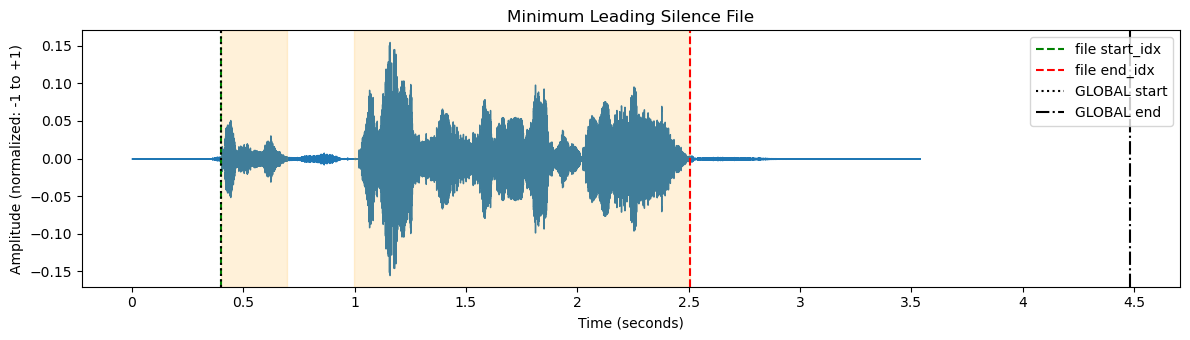

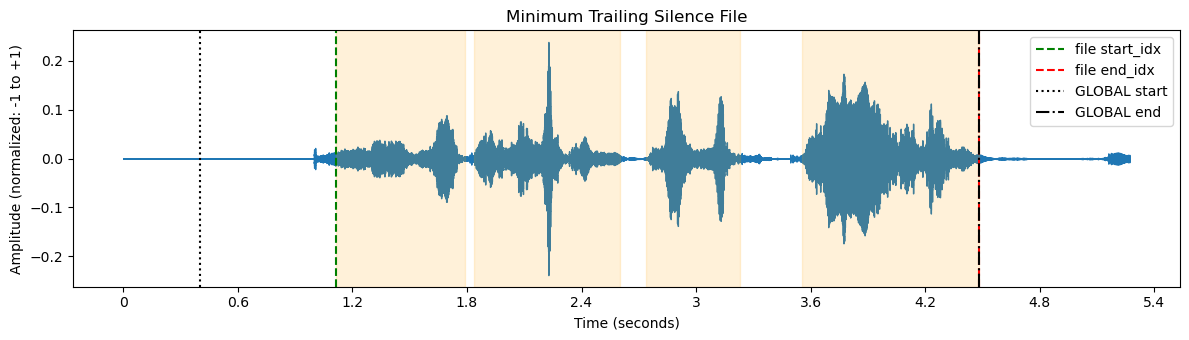

In [33]:
# Process the dataset
silence_df, global_start, global_end = process_dataset(df_ravdess,
                                                       top_db,
                                                       min_duration,
                                                       min_offset)

print("Global start:", global_start, f"({global_start/sr:.3f} s)")
print("Global end:", global_end, f"({global_end/sr:.3f} s)")
print("Final standardized length:", global_end - global_start + 1,
      f"samples ({(global_end-global_start+1)/sr:.3f} s)")

# Pick verification files
min_leading_row = silence_df.loc[silence_df["start_idx"].idxmin()]
min_trailing_row = silence_df.loc[silence_df["end_idx"].idxmax()]

# Plot verification - save min leading silence
y = min_leading_row["y"]
intervals = min_leading_row["intervals"]
start_idx = min_leading_row["start_idx"]
end_idx = min_leading_row["end_idx"]

plt.figure(figsize=(12,3.5))
librosa.display.waveshow(y, sr=sr)
for (s,e) in intervals:
    plt.axvspan(s/sr, e/sr, alpha=0.15, color='orange')
plt.axvline(start_idx/sr, color='g', linestyle='--', label='file start_idx')
plt.axvline(end_idx/sr, color='r', linestyle='--', label='file end_idx')
plt.axvline(global_start/sr, color='k', linestyle=':', linewidth=1.5, label='GLOBAL start')
plt.axvline(global_end/sr, color='k', linestyle='-.', linewidth=1.5, label='GLOBAL end')
plt.title("Minimum Leading Silence File")
plt.xlabel("Time (seconds)")
plt.ylabel("Amplitude (normalized: -1 to +1)")
plt.legend(loc='upper right')
plt.tight_layout()
plt.savefig('../output/EDA_plots/11_min_leading_silence.png', dpi=300, bbox_inches='tight')
plt.show()

# Plot verification - save min trailing silence
y = min_trailing_row["y"]
intervals = min_trailing_row["intervals"]
start_idx = min_trailing_row["start_idx"]
end_idx = min_trailing_row["end_idx"]

plt.figure(figsize=(12,3.5))
librosa.display.waveshow(y, sr=sr)
for (s,e) in intervals:
    plt.axvspan(s/sr, e/sr, alpha=0.15, color='orange')
plt.axvline(start_idx/sr, color='g', linestyle='--', label='file start_idx')
plt.axvline(end_idx/sr, color='r', linestyle='--', label='file end_idx')
plt.axvline(global_start/sr, color='k', linestyle=':', linewidth=1.5, label='GLOBAL start')
plt.axvline(global_end/sr, color='k', linestyle='-.', linewidth=1.5, label='GLOBAL end')
plt.title("Minimum Trailing Silence File")
plt.xlabel("Time (seconds)")
plt.ylabel("Amplitude (normalized: -1 to +1)")
plt.legend(loc='upper right')
plt.tight_layout()
plt.savefig('../output/EDA_plots/12_min_trailing_silence.png', dpi=300, bbox_inches='tight')
plt.show()

### Adding the Audio Samples as cols to DF

In [34]:
target_len = global_end - global_start + 1
trimmed_audios = []

for i, row in silence_df.iterrows():
    y = row["y"]
    
    # Slice from global_start to global_end (if available)
    trimmed = y[global_start:global_end+1]
    
    # Pad with zeros if shorter
    if len(trimmed) < target_len:
        trimmed = np.pad(trimmed, (0, target_len - len(trimmed)), mode="constant")
    
    trimmed_audios.append(trimmed)

# Confirm all lengths are now equal
lengths = [len(a) for a in trimmed_audios]
print("Unique lengths after trimming + padding:", set(lengths))  # should be {target_len}

# Build DataFrame
samples_df = pd.DataFrame(trimmed_audios, columns=[f"y_{i}" for i in range(target_len)])
final_df = pd.concat([df_ravdess.reset_index(drop=True), samples_df], axis=1)

print(final_df.shape)
final_df.head()

Unique lengths after trimming + padding: {89996}
(1440, 90007)


,path,modality,vocal_channel,intensity,statement,repetition,actor,emotion,gender,loudness_db,...,y_89986,y_89987,y_89988,y_89989,y_89990,y_89991,y_89992,y_89993,y_89994,y_89995
0,../data/ravdess_data/Actor_16/03-01-05-01-02-0...,3,1,1,2,1,16,angry,Female,-64.729790,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,../data/ravdess_data/Actor_16/03-01-06-01-02-0...,3,1,1,2,2,16,fearful,Female,-65.943779,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,../data/ravdess_data/Actor_16/03-01-06-02-01-0...,3,1,2,1,2,16,fearful,Female,-51.392780,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,../data/ravdess_data/Actor_16/03-01-05-02-01-0...,3,1,2,1,1,16,angry,Female,-59.114307,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,../data/ravdess_data/Actor_16/03-01-07-01-01-0...,3,1,1,1,1,16,disgust,Female,-69.102135,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Listen to Trimmed Audio Samples

Compare the original and trimmed versions of the edge case files:

#### Minimum Leading Silence File

In [35]:
print("Original audio (with silence):")
display(ipd.Audio(min_leading_row["path"]))

min_leading_idx = silence_df["start_idx"].idxmin()
print("\nTrimmed audio (silence removed):")
display(ipd.Audio(trimmed_audios[min_leading_idx], rate=sr))

Original audio (with silence):



Trimmed audio (silence removed):


#### Minimum Trailing Silence File

In [36]:
print("Original audio (with silence):")
display(ipd.Audio(min_trailing_row["path"]))

min_trailing_idx = silence_df["end_idx"].idxmax()
print("\nTrimmed audio (silence removed):")
display(ipd.Audio(trimmed_audios[min_trailing_idx], rate=sr))

Original audio (with silence):



Trimmed audio (silence removed):


### Export Trimmed Audio Samples for Presentation

Export the trimmed audio files so they can be embedded in the Quarto presentation:

In [37]:
import soundfile as sf

# Create output directory
output_dir = "../output/sample_audio"
os.makedirs(output_dir, exist_ok=True)

# Get the indices for min leading and min trailing silence files
min_leading_idx = silence_df["start_idx"].idxmin()
min_trailing_idx = silence_df["end_idx"].idxmax()

# Export trimmed audio files
sf.write(f"{output_dir}/min_leading_trimmed.wav", trimmed_audios[min_leading_idx], sr)
sf.write(f"{output_dir}/min_trailing_trimmed.wav", trimmed_audios[min_trailing_idx], sr)

# Get the original file paths for reference
print(f"Minimum leading silence file: {min_leading_row['path']}")
print(f"Minimum trailing silence file: {min_trailing_row['path']}")
print(f"\nTrimmed files saved to {output_dir}/")

Minimum leading silence file: ../data/ravdess_data/Actor_20/03-01-08-02-02-01-20.wav
Minimum trailing silence file: ../data/ravdess_data/Actor_19/03-01-07-02-01-02-19.wav

Trimmed files saved to ../output/sample_audio/


Shortest file original length: 64745
Trimmed+Padded length: 89996
Target length: 89996


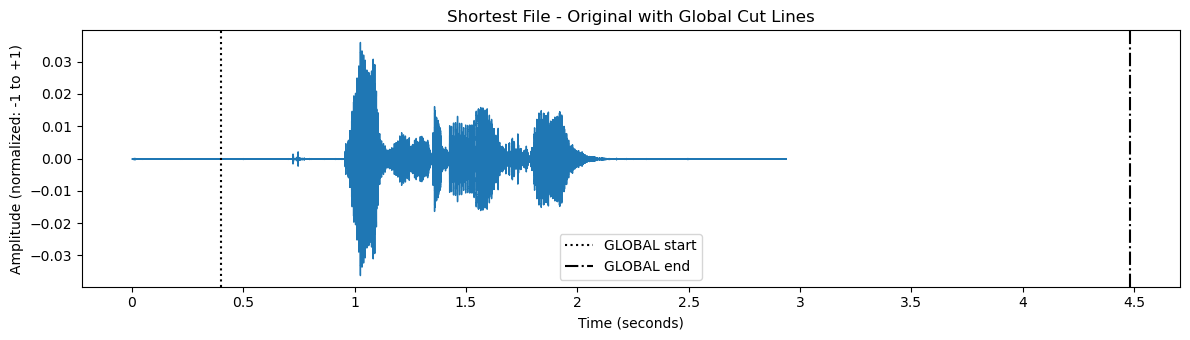

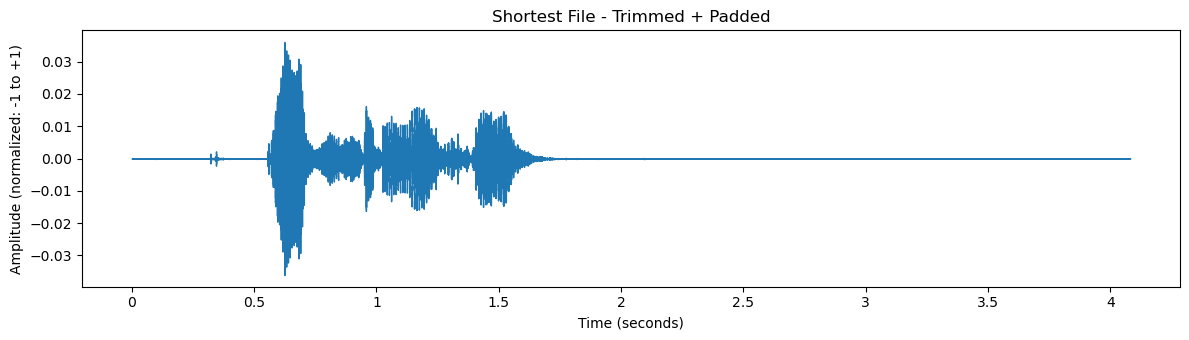

Longest file original length: 116247
Trimmed length: 89996
Target length: 89996


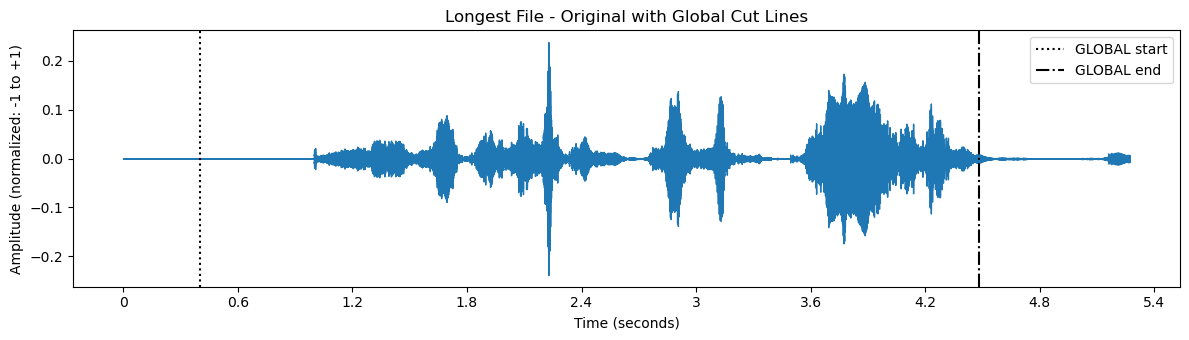

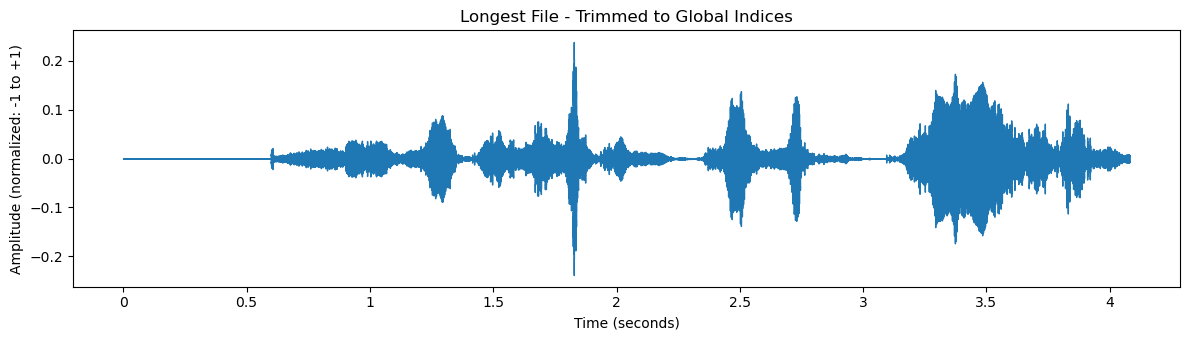

In [38]:
# --- Shortest file check ---
shortest_idx = np.argmin([len(y) for y in silence_df["y"]])
row_short = silence_df.iloc[shortest_idx]
y_original_short = row_short["y"]
y_trimmed_short = trimmed_audios[shortest_idx]

print("Shortest file original length:", len(y_original_short))
print("Trimmed+Padded length:", len(y_trimmed_short))
print("Target length:", target_len)

# Plot shortest original
plt.figure(figsize=(12,3.5))
librosa.display.waveshow(y_original_short, sr=sr)
plt.axvline(global_start/sr, color='k', linestyle=':', linewidth=1.5, label='GLOBAL start')
plt.axvline(global_end/sr, color='k', linestyle='-.', linewidth=1.5, label='GLOBAL end')
plt.title("Shortest File - Original with Global Cut Lines")
plt.xlabel("Time (seconds)")
plt.ylabel("Amplitude (normalized: -1 to +1)")
plt.legend()
plt.tight_layout()
plt.show()

# Plot shortest trimmed+padded
plt.figure(figsize=(12,3.5))
librosa.display.waveshow(y_trimmed_short, sr=sr)
plt.title("Shortest File - Trimmed + Padded")
plt.xlabel("Time (seconds)")
plt.ylabel("Amplitude (normalized: -1 to +1)")
plt.tight_layout()
plt.show()


# --- Longest file check ---
longest_idx = np.argmax([len(y) for y in silence_df["y"]])
row_long = silence_df.iloc[longest_idx]
y_original_long = row_long["y"]
y_trimmed_long = trimmed_audios[longest_idx]

print("Longest file original length:", len(y_original_long))
print("Trimmed length:", len(y_trimmed_long))
print("Target length:", target_len)

# Plot longest original
plt.figure(figsize=(12,3.5))
librosa.display.waveshow(y_original_long, sr=sr)
plt.axvline(global_start/sr, color='k', linestyle=':', linewidth=1.5, label='GLOBAL start')
plt.axvline(global_end/sr, color='k', linestyle='-.', linewidth=1.5, label='GLOBAL end')
plt.title("Longest File - Original with Global Cut Lines")
plt.xlabel("Time (seconds)")
plt.ylabel("Amplitude (normalized: -1 to +1)")
plt.legend()
plt.tight_layout()
plt.show()

# Plot longest trimmed
plt.figure(figsize=(12,3.5))
librosa.display.waveshow(y_trimmed_long, sr=sr)
plt.title("Longest File - Trimmed to Global Indices")
plt.xlabel("Time (seconds)")
plt.ylabel("Amplitude (normalized: -1 to +1)")
plt.tight_layout()
plt.show()

In [ ]:
final_df = final_df.drop(columns=['path',
                                  'duration'])
final_df

,modality,vocal_channel,intensity,statement,repetition,actor,emotion,gender,loudness_db,y_0,...,y_89986,y_89987,y_89988,y_89989,y_89990,y_89991,y_89992,y_89993,y_89994,y_89995
0,3,1,1,2,1,16,angry,Female,-64.729790,0.000000e+00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,3,1,1,2,2,16,fearful,Female,-65.943779,2.051093e-08,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3,1,2,1,2,16,fearful,Female,-51.392780,-8.404510e-06,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,3,1,2,1,1,16,angry,Female,-59.114307,0.000000e+00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,3,1,1,1,1,16,disgust,Female,-69.102135,0.000000e+00,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1435,3,1,2,2,2,8,happy,Female,-57.352631,8.016690e-05,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1436,3,1,1,1,2,8,happy,Female,-64.781517,4.014514e-07,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1437,3,1,2,1,1,8,calm,Female,-67.697044,-4.947469e-05,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1438,3,1,1,2,1,8,calm,Female,-66.581841,-9.008037e-05,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [45]:
final_df.to_csv("../data/ABT_1_ravdess.csv", index=False)

### Analytics Base Table (ABT) - Final Structure

**What we've created:**
- **Shape**: 1,440 rows × 90,005 columns
- **Rows**: Each row represents one audio file (emotion sample)
- **Columns**:
  - **8 metadata columns**: modality, vocal_channel, intensity, statement, repetition, actor, gender, loudness_db
  - **1 target column**: emotion (8 classes: angry, calm, disgust, fearful, happy, neutral, sad, surprised)
  - **89,996 audio feature columns**: Standardized audio samples (y_0 to y_89995)

**Key Characteristics:**
- All audio samples trimmed to identical length (89,996 samples ≈ 4.08 seconds at 22.05kHz)
- Global silence boundaries applied consistently across all files
- Zero-padding used for files shorter than the target length
- **Leakage prevention**: Removed `path`, `emotion_code`, and `duration` columns to prevent target leakage

**Metadata Columns Retained:**
- `modality` (3) - Audio-visual indicator (constant for this dataset)
- `vocal_channel` (1) - Speech indicator (constant for this dataset)
- `intensity` (1 or 2) - Normal or strong emotional intensity
- `statement` (1 or 2) - Which statement was spoken
- `repetition` (1 or 2) - First or second repetition
- `actor` (1-24) - Actor ID (odd=male, even=female)
- `gender` (Male/Female) - Derived from actor ID
- `loudness_db` - Average loudness in decibels

**Target Variable:**
- `emotion` - 8 balanced classes for emotion classification

**Next Steps:**
This ABT will be used for:
1. Baseline modeling with raw audio features
2. Feature extraction (MFCCs, spectrograms) for traditional ML
3. Deep learning model training

The ABT is saved as `ABT_1_ravdess.csv` for reproducibility.